In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
POINTS = 500

In [27]:
def f(x):
    return np.sin(2*x) * np.sin(x**2/np.pi)

In [28]:
def calculate_coefficient_z_i1(z_i, t_i, t_i1, y_i, y_i1):
    # t_i, t_i1 - interpolation nodes, y - values in those nodes, z_i - previous coefficient
    return -z_i + 2 * (y_i1 - y_i) / (t_i1 - t_i)

In [29]:
def calculate_coefficients_q(z0, t, y):
    n = len(t)
    z = np.empty(n)
    z[0] = z0
    for i in range(n-1):
        z[i + 1] = calculate_coefficient_z_i1(z[i], t[i], t[i + 1], y[i], y[i + 1])
    return z

In [30]:
def compute_Qi(i, z, t, y):
    a = (z[i + 1] - z[i]) / (2 * (t[i+1] - t[i]))
    b = z[i]
    c = y[i]
    return lambda x: a * (x - t[i]) ** 2 + b * (x - t[i]) + c

In [55]:
def Q(x, z, t, y):
    indexes = np.searchsorted(t, x) - 1
    if indexes[0] == -1:
        indexes[0] = 0
    Qi = compute_Qi(indexes, z, t, y)
    return Qi(x)

In [32]:
def quadratic_spline_interpolation(t, y, z0):
    z = calculate_coefficients_q(z0, t, y)
    return lambda x: Q(x, z, t, y)

In [111]:
def create_equation_system(n, t):
    result = np.empty((n,n))
    for row in range(n):
        for column in range(n):
            if abs(row - column) > 1: # banded matrix
                result[row][column] =  0
            elif row == 0:              # edge cases
                if column == 0:
                    result[row][column] = 1
                result[row][column] = 0
            elif row == n - 1:
                if column == n - 1:
                    result[row][column] =  1
                result[row][column] = 0
            elif row - column == 1:      # lower diagonal
                result[row][column] = t[row] - t[column]
            elif row - column == 0:      # diagonal
                result[row][column] = 2 * (t[row+1] - t[row-1])
            elif row - column == 1:      #upper diagonal
                result[row][column] = t[column] - t[row]
    return result

In [92]:
def create_right_side_vector(n, z0, t, y):
    result = np.empty((n,))
    result[0] = z0
    result[n-1] = z0
    for i in range(1,n-1):
        result[i] = 6 * ((y[i+1] - y[i]) / (t[i+1] - t[i]) - (y[i] - y[i-1]) / (t[i] - t[i-1]))
    return result

In [117]:
def calculate_coefficients_c(z0, t, y):
    n = len(t)
    z = np.empty((n,))
    h = np.empty((n - 1, ))
    b = np.empty((n - 1, ))
    u = np.empty((n - 1, ))
    v = np.empty((n - 1, ))
    for i in range(n - 1):
        h[i] = t[i+1] - y[i]
        b[i] = (y[i+1] - y[i]) / h[i]
    u[1] = 2 * (h[1] + h[0])
    v[1] = 6 * (b[1] - b[0])
    for i in range(2, n - 1):
        u[i] = 2 * (h[i] + h[i-1]) - h[i-1]**2 / u[i-1]
        v[i] = 6 * (b[i] - h[i-1]) - h[i-1] * v[i-1] / u[i-1]
    z[n-1] = z0
    for i in range(n - 2, 0, -1):
        z[i] = (v[i] - h[i] * z[i+1]) / u[i]
    z[0] = z0
    return z

In [94]:
def compute_Si(i, z, t, y):
    h = t[i+1] - t[i]
    a = z[i+1] / (6 * h)
    b = z[i] / (6 * h)
    c = y[i+1] / h - h * z[i+1] / 6
    d = y[i] / h - h * z[i] / 6
    return lambda x: a * (x - t[i])**3 + b * (t[i+1] - x)** 3 + c * (x - t[i]) + d * (t[i+1] - x)

In [95]:
def S(x, z, t, y):
    indexes = np.searchsorted(t, x) - 1
    if indexes[0] == -1:
        indexes[0] = 0
    Si = compute_Si(indexes, z, t, y)
    return Si(x)

In [116]:
def cubic_spline_interpolation(t, y, z0):
    z = calculate_coefficients_c(z0, t, y)
    return lambda x: S(x, z, t, y)

In [97]:
def interpolate(x_print, spline_polynomial):
    return spline_polynomial(x_print)

In [98]:
def exercise(a, b, n, z0, spline_type='drugi'):
    print("Stopień: {0:s}, liczba węzłów: {1:d}".format(spline_type, n))
    if spline_type == 'drugi':
        spline_fun = quadratic_spline_interpolation
    else:
        spline_fun = cubic_spline_interpolation
    x_inter = np.linspace(a, b, n)
    x_print = np.linspace(a, b, POINTS)
    y_inter = f(x_inter)
    y_print = f(x_print)
    p_print = interpolate(x_print, spline_fun(x_inter, y_inter, z0))
    print_errors(y_print, p_print)
    print_plots(x_inter, x_print, y_inter, y_print, p_print)

In [99]:
def print_errors(y_print, p_print):
    print('Błąd interpolacji(norma euklidesowa):', np.linalg.norm(y_print-p_print) / POINTS)
    print('Błąd interpolacji(norma maksimum):', np.linalg.norm(y_print-p_print, ord=np.inf))

In [100]:
def print_plots(x_inter, x_print, y_inter, y_print, p_print):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(x_print, p_print, label="W(x)")
    ax.plot(x_print, y_print, label="f(x)")
    ax.plot(x_inter, y_inter, '*', label='Węzły interpolacji')
    ax.set_title('elo')
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend()
    plt.show()

Stopień: trzeci, liczba węzłów: 10
Błąd interpolacji(norma euklidesowa): 0.01563723519437707
Błąd interpolacji(norma maksimum): 0.980093369500881


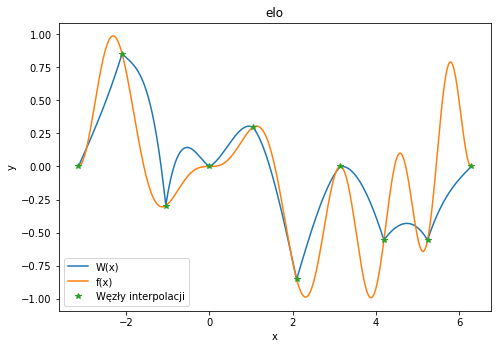

In [118]:
exercise(-np.pi, 2*np.pi, 10, 0, 'trzeci')